In [3]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString,Point, Polygon, shape
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd
import io
from PIL import Image
import requests
from io import BytesIO
import os
import pickle
from tqdm import tqdm
import dpkt
# from Utils import get_foreground_point_cloud
from LiDARBase import parse_one_packet,calc_precise_azimuth,laser_id,Data_order,arg_omega,calc_timing_offsets,get_foreground_point_cloud
from Utils import *
from GenBckFile import *
# use sobel filter to get horizontal gradient
from scipy import ndimage
from scipy.signal import convolve2d

/Users/zhihiuchen/Documents/Tracking/Lidar-Tracker/RaspberryPi/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


pygame 2.5.2 (SDL 2.28.3, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# unix time to utc time to pacific time
def unix2utc(unix_time):
    return pd.to_datetime(unix_time,unit='s').tz_localize('UTC').tz_convert('US/Pacific')
def load_pcap(file_path):
    try:
        fpcap = open(file_path, 'rb')
        eth_reader = dpkt.pcap.Reader(fpcap)
    except Exception as ex:
        print(str(ex))
        return None
    return eth_reader
    
def read_packets_offline(pcap_file_path):
    eth_reader = load_pcap(pcap_file_path)
    while True:
        # Simulate reading a packet from the Ethernet
        try:
            ts,buf = next(eth_reader)
        except StopIteration:
            return None
        eth = dpkt.ethernet.Ethernet(buf)
        if eth.type == 2048: # for ipv4
            if (type(eth.data.data) == dpkt.udp.UDP):# for ipv4
                data = eth.data.data.data
                packet_status = eth.data.data.sport
                if packet_status == 2368:
                    if len(data) != 1206:
                        continue
            # raw_packet = np.random.rand(20000,2) * 600  # Placeholder for actual packet data
                    yield (ts,data)
                    
def parse_packets(packet_gen):
    
    culmulative_azimuth_values = []
    culmulative_laser_ids = []
    culmulative_distances = []
    # culmulative_intensities = []
    Td_map = np.zeros((32,1800))
    # Intens_map = np.zeros((32,1800))
    next_ts = 0
    packet = next(packet_gen)
    if packet is None:
        return None
    ts,raw_packet = packet
    distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
    next_ts = ts + 0.1 # 0.1sec
    azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
    culmulative_azimuth_values.append(azimuth)
    culmulative_laser_ids.append(laser_id)
    culmulative_distances.append(distances)
            
    break_flag = False
    while True:
        if break_flag:
            break  
        while True:
            try:
                packet = next(packet_gen)
            except StopIteration:
                break_flag = True
                break
            ts,raw_packet = packet
            # Placeholder for parsing logic; here we just pass the data through
            distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
            # flag = self.if_rollover(azimuth_per_block,Initial_azimuth)
            azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
            
            if ts > next_ts:
                
                if len(culmulative_azimuth_values) > 0:
                    
                    culmulative_azimuth_values = np.concatenate(culmulative_azimuth_values,axis = 1)
                    culmulative_azimuth_values += Data_order[:,1].reshape(-1,1)
                    culmulative_laser_ids = np.concatenate(culmulative_laser_ids,axis = 1).flatten()
                    culmulative_distances = np.concatenate(culmulative_distances,axis = 1).flatten()
                    # culmulative_intensities = np.concatenate(culmulative_intensities,axis = 1).flatten()
                    culmulative_azimuth_inds = np.around(culmulative_azimuth_values/0.2).astype('int').flatten()
                    culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)] = culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)]%1799

                    Td_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_distances
                    # Intens_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_intensities
                    
                    yield Td_map[arg_omega,:] #32*1800
                else:
                    yield Td_map,ts #32*1800

                culmulative_azimuth_values = []
                culmulative_laser_ids = []
                culmulative_distances = []
                # culmulative_intensities = []

                Td_map = np.zeros((32,1800))
                # Intens_map = np.zeros((32,1800))
                next_ts += 0.1
                break
            else:
                culmulative_azimuth_values.append(azimuth)
                culmulative_laser_ids.append(laser_id)
                culmulative_distances.append(distances)
                # culmulative_intensities.append(intensities)
    return None

In [6]:
Td_maps = []
pcap_file_path = r'../../../Data/9thVir/2024-03-14-23-30-00.pcap'
packets_gen = read_packets_offline(pcap_file_path)
packet = next(packets_gen)
Initial_ts,raw_packet = packet

packets_gen = read_packets_offline(pcap_file_path)
td_gen = parse_packets(packets_gen)
for Td_map in tqdm(td_gen):
    Td_maps.append(Td_map)

17989it [04:39, 64.38it/s]


In [7]:

background_data = np.array(Td_maps)
thred_map = gen_bckmap(np.array(background_data), N = 10,d_thred = 0.1,bck_n = 3)         

100%|██████████| 32/32 [01:12<00:00,  2.25s/it]


In [ ]:
np.save('./thred_map.npy',thred_map)
thred_map = np.load('./thred_map.npy')

In [8]:
bck_radius = 0.2
vertical_limits = [0,31]
lane_drawer = LaneDrawer() # lane drawer for queue detection
lane_drawer.update_lane_gdf()

Lane zone updated


In [9]:
count_thred = 3
time_space_series = [] # t x laen# x lane_section#
for Td_map in tqdm(Td_maps):
    
    data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                            Td_map,vertical_limits)
    if len(data_raw) == 0:
        time_space_series.append(None)
        continue
    lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                                lane_drawer.lane_gdf,
                                                                                data_raw,point_labels)
    activation_profile = []
    for lane_counts in lane_section_foreground_point_counts:
        occupation = np.array(lane_counts) > count_thred
        activation_profile.append(occupation)
    time_space_series.append(activation_profile)
# test_time_space_series = np.array(test_time_space_series)

100%|██████████| 17989/17989 [11:20<00:00, 26.42it/s]


In [10]:
def get_merged_activation(activation_start,activation_end,lane_activation):
    lane_activation = lane_activation.copy()
    activation_start,activation_end = find_concecutive_activation(lane_activation)
    for i in range(1,len(activation_end)):
        if activation_start[i] - activation_end[i-1] < 6:
            lane_activation[activation_end[i-1]:activation_start[i]] = True
    return lane_activation

def find_concecutive_activation(activation):
    activation_start = []
    activation_end = []
    activation_flag = False
    for i in range(len(activation)):

        if activation[i] == True and activation_flag == False:
            activation_start.append(i)
            activation_flag = True
        elif activation[i] == False and activation_flag == True:
            activation_end.append(i)
            activation_flag = False
    return activation_start,activation_end

In [346]:
lane_ind = 2
lane_activation_profile = []
for t in range(len(time_space_series)):
    lane_activation_cur = time_space_series[t][lane_ind]
    lane_activation_profile.append(lane_activation_cur)
lane_activation_profile = np.array(lane_activation_profile,dtype=int)

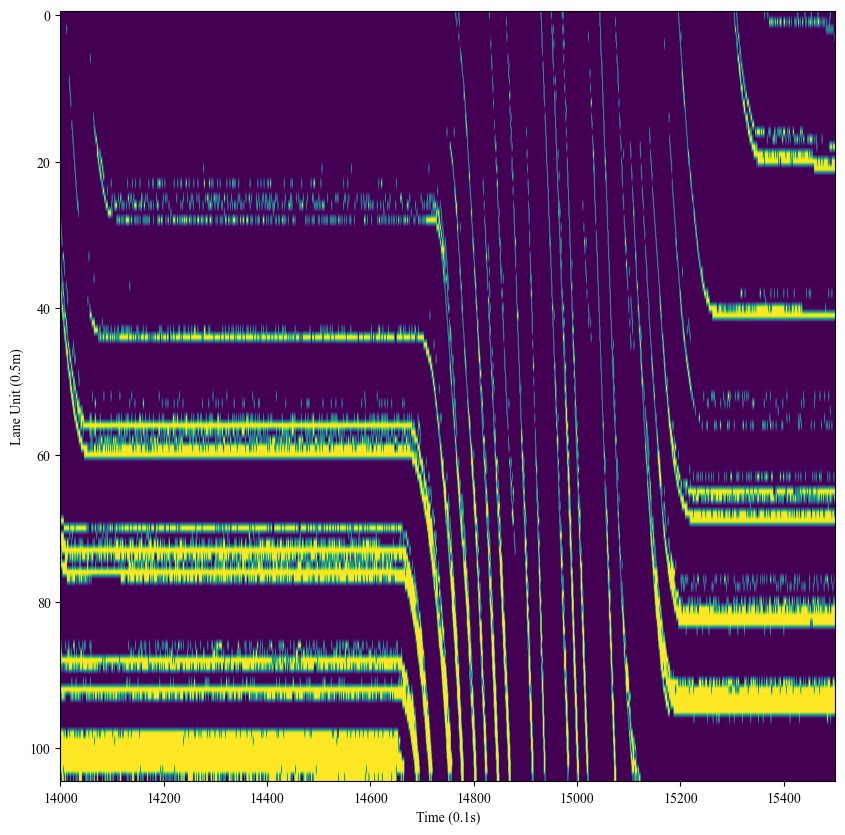

In [397]:
plt.figure(figsize = (10,10))
plt.imshow(lane_activation_profile.T,aspect = 'auto',interpolation = None)
plt.xlabel('Time (0.1s)')
plt.ylabel('Lane Unit (0.5m)')
plt.xlim(14000,15500)
plt.show()

In [378]:
lane_activation_profile_T = lane_activation_profile.T 

In [375]:
stop_specturm = ndimage.sobel(lane_activation_profile.T, 0)  # horizontal gradient
travel_specturm = ndimage.sobel(lane_activation_profile.T, 1)  # horizontal gradient
magnitude = np.sqrt(stop_specturm**2 + travel_specturm**2)

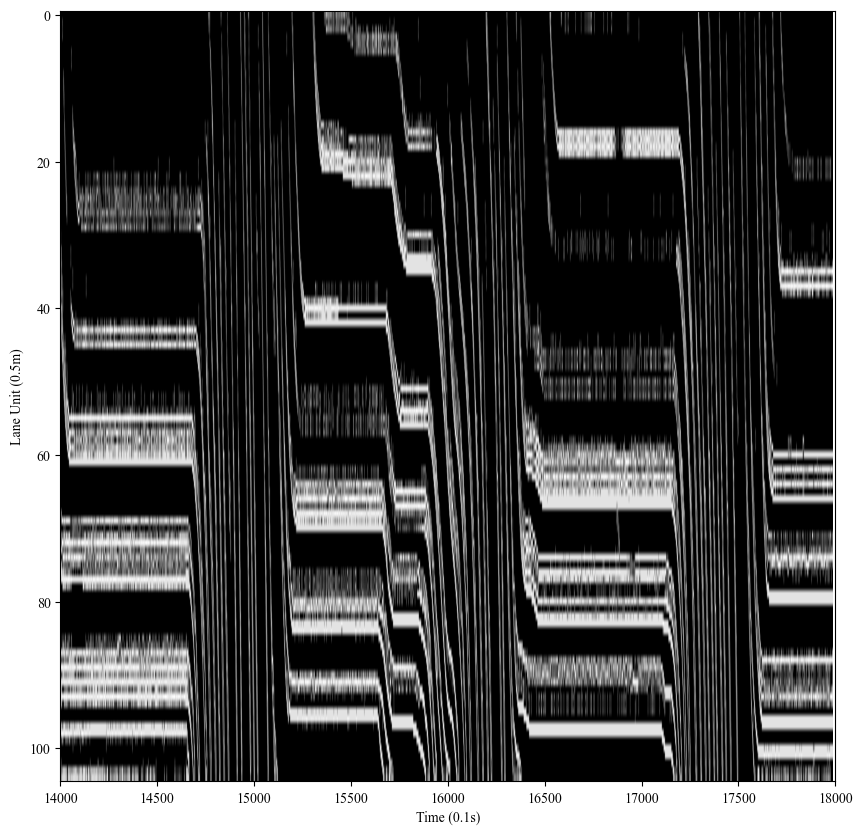

In [377]:
plt.figure(figsize = (10,10))
# increase distincness of the image
plt.imshow(magnitude,aspect = 'auto',cmap='gray',interpolation = None)
# plt.imshow(sobel_v,aspect = 'auto',cmap='gray',interpolation = None)
plt.xlabel('Time (0.1s)')
plt.ylabel('Lane Unit (0.5m)')
plt.xlim(14000,18000)# plt.ylim(0,32)
plt.show()

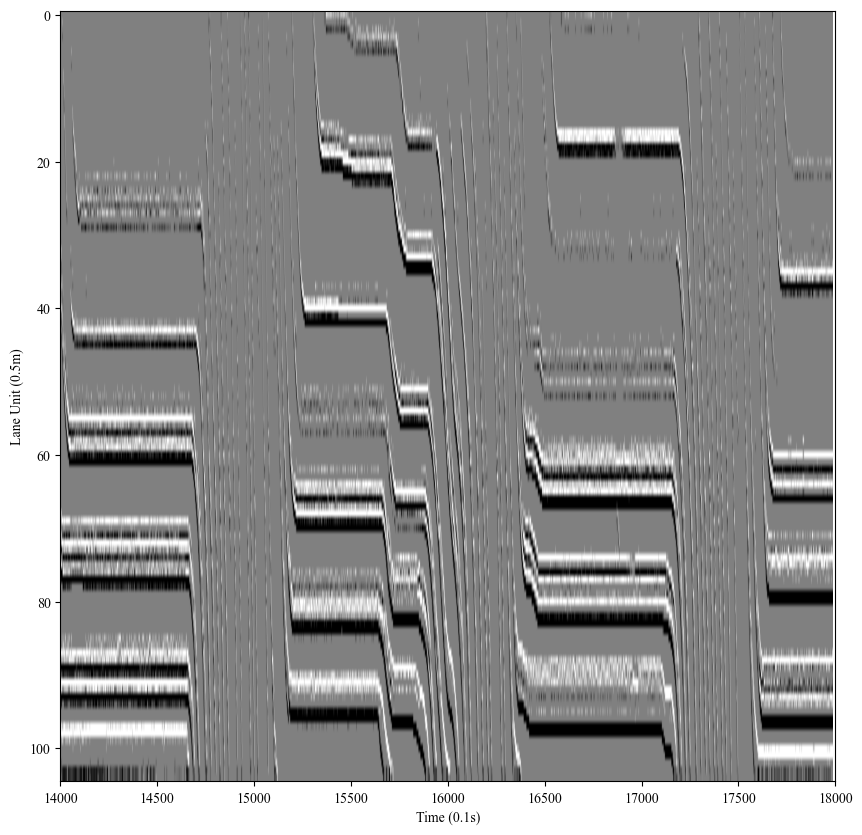

In [376]:
plt.figure(figsize = (10,10))
# increase distincness of the image
plt.imshow(stop_specturm,aspect = 'auto',cmap='gray',interpolation = None)
# plt.imshow(sobel_v,aspect = 'auto',cmap='gray',interpolation = None)
plt.xlabel('Time (0.1s)')
plt.ylabel('Lane Unit (0.5m)')
plt.xlim(14000,18000)# plt.ylim(0,32)
plt.show()

In [ ]:
lane_activation_profile.T

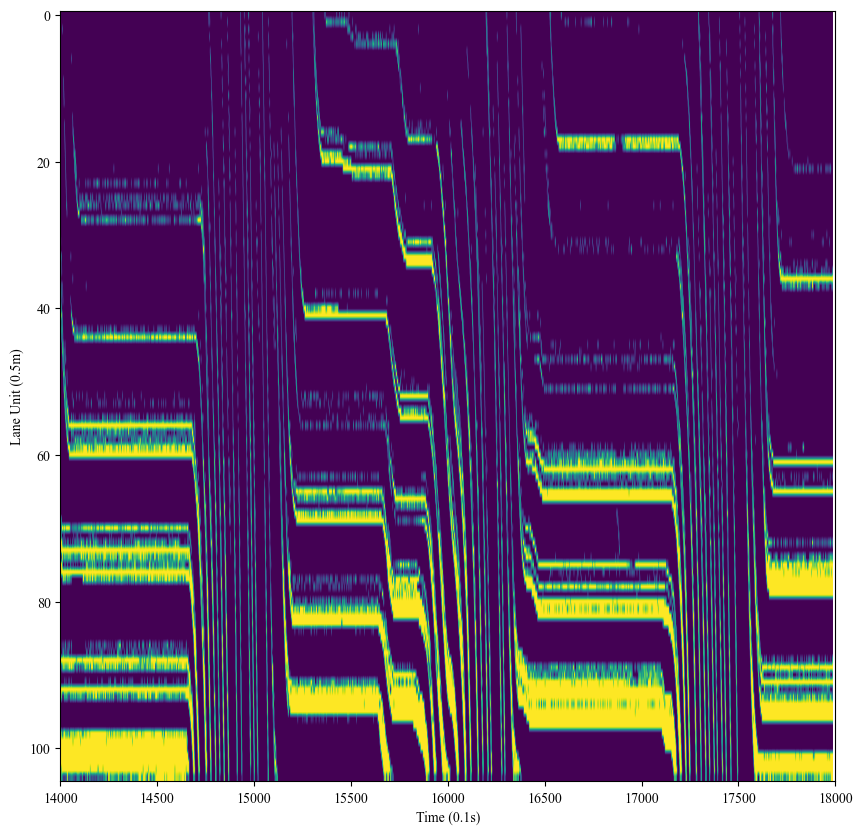

In [449]:
plt.figure(figsize = (10,10))
plt.imshow(lane_activation_profile.T,aspect = 'auto')
plt.xlabel('Time (0.1s)')
plt.ylabel('Lane Unit (0.5m)')
# plt.ylim(16000,18000)
plt.xlim(14000,18000)
plt.show()

In [450]:
high_queue_specturm = lane_activation_profile.T
stop_time_thred = 2 # sec 
screening_mask = np.ones((1,stop_time_thred * 10))
# use screening mask to convolve the queue specturm
queue_stop = convolve2d(high_queue_specturm,screening_mask)
queue_length_indicator = queue_stop > 0.4 * stop_time_thred * 10
total_queue_length_curve = []
for i in range(0,queue_length_indicator.shape[1],1):
    stops = np.where(queue_length_indicator[:,i])[0]
    if len(stops) == 0:
        total_queue_length_curve.append(0)
        continue
    queue_length_t = (queue_length_indicator.shape[0] - stops.min())*0.5
    total_queue_length_curve.append(queue_length_t)

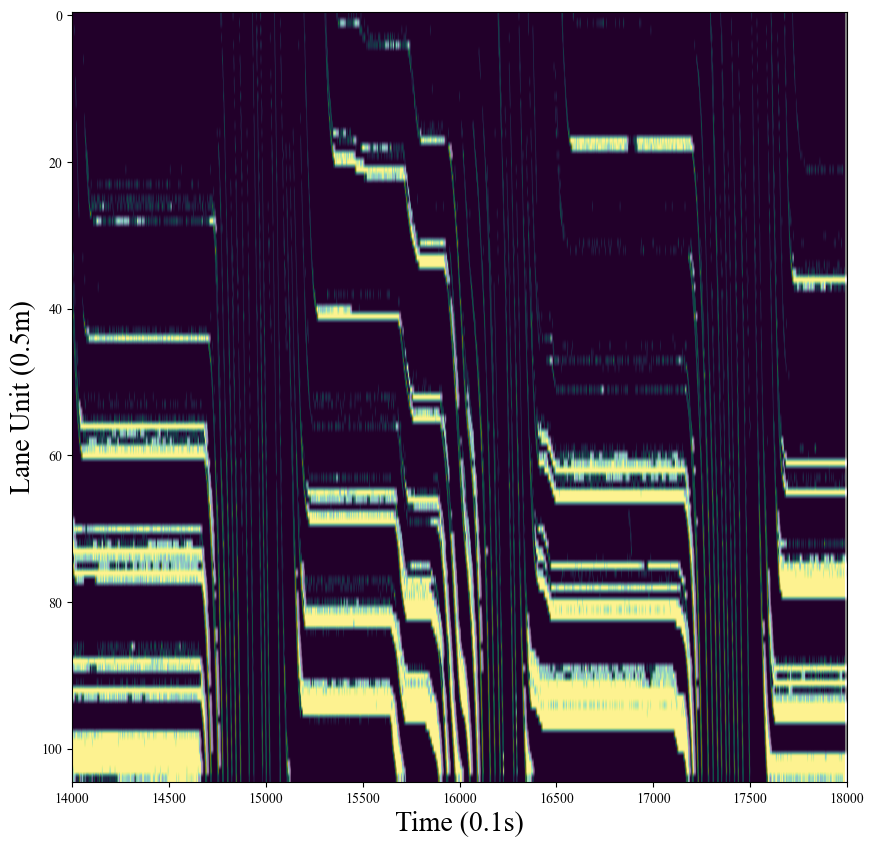

In [451]:

# use times new roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize = (10,10))
plt.imshow(high_queue_specturm,aspect = 'auto')
plt.imshow(queue_length_indicator,alpha=0.5,aspect = 'auto',cmap='gray')
plt.xlabel('Time (0.1s)',fontsize = 20)
plt.ylabel('Lane Unit (0.5m)',fontsize = 20)
# plt.xlim(620,630)
plt.xlim(14000,18000)

plt.show()

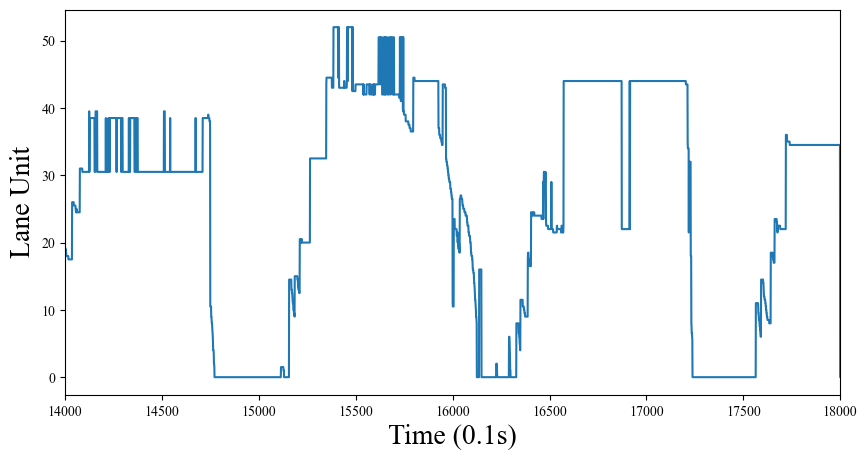

In [454]:

plt.figure(figsize = (10,5))
plt.plot(total_queue_length_curve)
plt.xlabel('Time (0.1s)',fontsize = 20)
plt.ylabel('Lane (meter)',fontsize = 20)
plt.xlim(14000,18000)
plt.show()


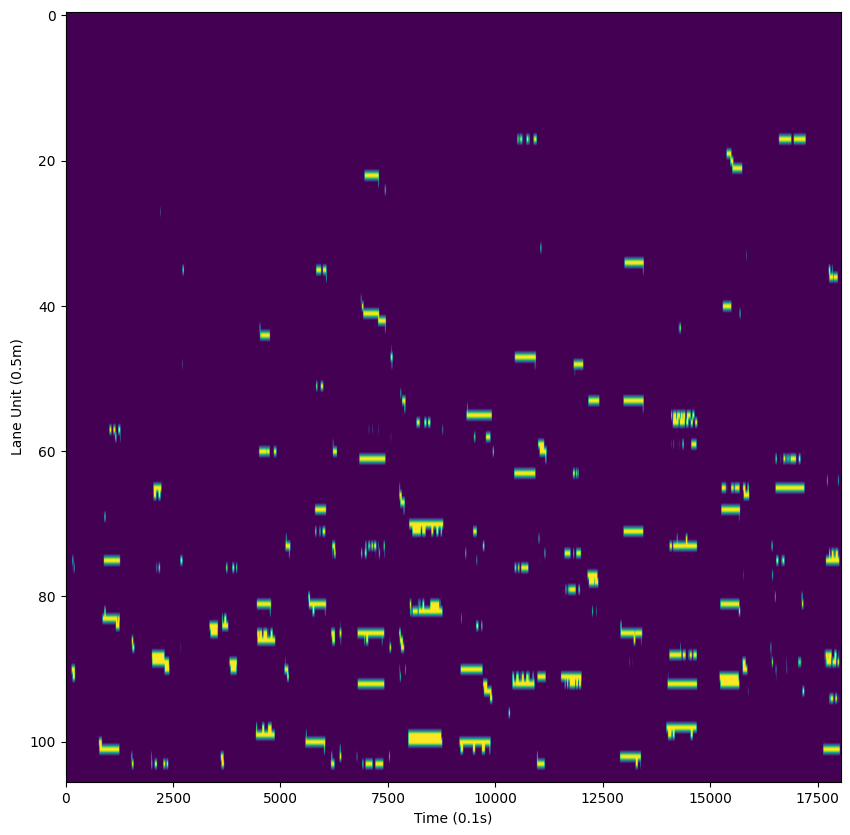

In [232]:
plt.figure(figsize = (10,10))
plt.imshow(queue_length_indicator,aspect = 'auto')
plt.xlabel('Time (0.1s)')
plt.ylabel('Lane Unit (0.5m)')
# plt.xlim(620,630)
plt.show()

In [150]:
queue_stop.

(105, 17998)

In [11]:
lane_ind = 2
total_queue = []
total_longitudinal_locations = []
total_speeds = []
for t in range(len(time_space_series) - 1):
    lane_activation_cur = time_space_series[t][lane_ind]
    lane_activation_next = time_space_series[t+1][lane_ind]
    
    activation_start,activation_end = find_concecutive_activation(lane_activation_cur)
    lane_activation_cur_ = get_merged_activation(activation_start,activation_end,lane_activation_cur)
    activation_start,activation_end = find_concecutive_activation(lane_activation_next)
    lane_activation_next_ = get_merged_activation(activation_start,activation_end,lane_activation_next)

    # the end activation is actually at the location of front of the vehicle
    _,activation_end_cur = find_concecutive_activation(lane_activation_cur_)
    _,activation_end_next = find_concecutive_activation(lane_activation_next_)
    activation_end_cur = np.array(activation_end_cur)
    activation_end_next = np.array(activation_end_next)
    # so we need an association between the two activations linear sum assignment, the constraint is that the distance between two activations should be less than 1m
    # we need to calculate the cost matrix
    # if either activation_end is 0, total_queue append 0
    if len(activation_end_cur) == 0 or len(activation_end_next) == 0:
        total_queue.append(0)
        continue
    cost_matrix = np.zeros((len(activation_end_cur),len(activation_end_next)))
    for i in range(len(activation_end_cur)):
        for j in range(len(activation_end_next)):
            dis = np.abs(activation_end_cur[i] - activation_end_next[j]) * 0.5
            if dis > 3:
                cost_matrix[i,j] = 1000
            else:
                cost_matrix[i,j] = dis
            
    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize = False)
    # calculate the speed
    speeds = []
    for i in range(len(row_ind)):
        speed = np.abs(activation_end_cur[row_ind[i]] - activation_end_next[col_ind[i]]) * 0.5
        if speed > 3:
            speed = 0
        speeds.append(speed)
    speeds = np.array(speeds)
    longitudinal_locations = activation_end_cur[row_ind] * 0.5
    total_longitudinal_locations.append(longitudinal_locations)
    total_speeds.append(speeds)
    # if speed is lower than 5km/h, we consider it as a queue
    queue = (speeds < 5).sum()
    # queue = (test_time_space_series.shape[1] - activation_end_cur[row_ind[speeds < 5]].min()) * 0.5
    # find the farthest queue
    total_queue.append(queue)

In [9]:
# use speed to map the scatter plot color 
plt.figure(figsize=(10,5))
for t in range(len(total_longitudinal_locations)):
    if len(total_longitudinal_locations[t]) == 0:
        continue
    for i in range(len(total_longitudinal_locations[t])):
        plt.scatter(t,total_longitudinal_locations[t][i],c = total_speeds[t][i],cmap = 'coolwarm', s = 3, alpha = 0.5)
plt.show()

KeyboardInterrupt: 

In [15]:
# 100 frame as a step (10 sec), calculate the mode queue in each step
queue_window = 300
total_queue_ = []
for i in range(0,len(total_queue),queue_window):
    total_queue_.append(np.array(total_queue[i:i+queue_window]).max())


In [16]:
InitialTs = unix2utc(Initial_ts)

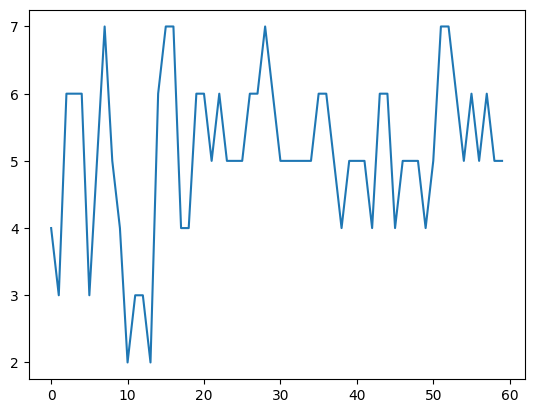

In [17]:
# plot the queue length
plt.plot(total_queue_)
plt.show()

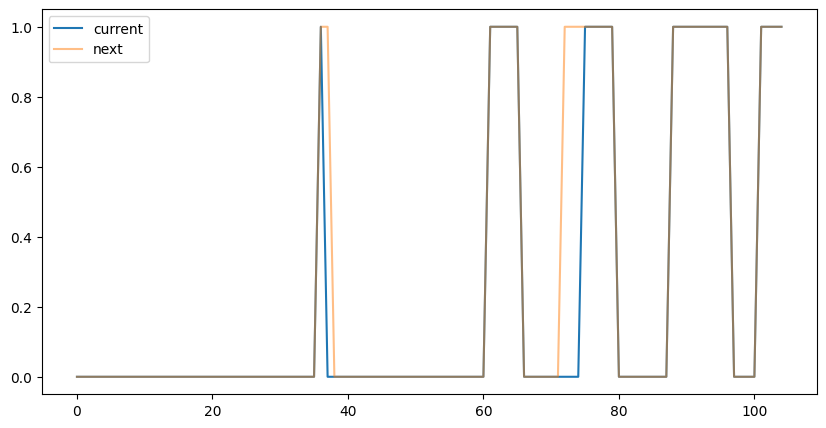

In [19]:
plt.figure(figsize=(10,5))
# 0.5 meter section length
plt.plot(lane_activation_cur_,label = 'current')
# plt.plot(lane_activation_cur)
plt.plot(lane_activation_next_,label = 'next',alpha = 0.5)
plt.legend()
# plt.xlim(120,130)
plt.show()

In [32]:
plt.figure(figsize = (10,10))
plt.imshow(test_time_space_series.T,aspect = 'auto')
plt.ylim(140,160)
plt.xlim(0,180)
plt.show()

NameError: name 'test_time_space_series' is not defined

<Figure size 1000x1000 with 0 Axes>

In [178]:
test_lane_poly = lane_subsections_poly[0] # END poly is the stop bar

In [172]:
pdf = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(lane_subsections_poly[0]))

In [175]:
pdf['id'] = np.arange(len(pdf))